# Parallel Model Fitting

In this notebook, we'll fit a simple ageing model to all of the counties in the United States. As before, we'll use `scipy.optimize` to perform the fitting, but we'll use python's `multiprocessing` library to perform these optimizations in parallel.

## When to use this technique
This technique is appropriate when we are modeling a large number of entirely independent but structurally identical systems. In this example, we're conceptualizing the population of counties to be influenced by aging and exogenous migration patterns. If we were to attempt to link the models together, for instance by specifying that the outmigration from one county needed to be accounted for as the inmigration to another county, we would need to perform a single large-scale optimization, or some form of hybrid.

In [1]:
%pylab inline
import pandas as pd
import pysd
import scipy.optimize
import multiprocessing
import numpy as np
import seaborn

Populating the interactive namespace from numpy and matplotlib


## Ingredients

#### Data
The first ingredient theat we'll use is census data from the 2000 and 2010 census:

In [37]:
data = pd.read_csv('../../data/Census/Males by decade and county.csv', header=[0,1], skiprows=[2])
data.head()

Unnamed: 0_level_0 Unnamed: 1_level_0  2000                                  \
  Unnamed: 0_level_1 Unnamed: 1_level_1 dec_1  dec_2 dec_3 dec_4  dec_5 dec_6   
0                  1                  1  3375   3630  2461  3407   3283  2319   
1                  1                  3  9323  10094  7600  9725  10379  8519   
2                  1                  5  2002   2198  2412  2465   2178  1699   
3                  1                  7  1546   1460  1680  1762   1624  1237   
4                  1                  9  3741   3615  3393  3901   3773  3007   

                      2010                                                 \
  dec_7 dec_8 dec_9  dec_1  dec_2 dec_3  dec_4  dec_5  dec_6  dec_7 dec_8   
0  1637   825   284   3867   4384  3082   3598   4148   3390   2293  1353   
1  6675  4711  1822  11446  12006  9976  11042  12517  12368  10623  6307   
2  1026   689   301   1673   1739  2260   2208   2233   1910   1490   739   
3   774   475   187   1471   1577  1798   2016   1928   1581   1140   579   
4  2227  1269   550   3741   4252  3312   3719   4129   3782   3052  1723   

         
  dec_9  
0   454  
1  2911  
2   324  
3   211  
4   652

#### Model
The model will be a simple ageing chain that groups individuals into 10 year cohorts.

In [38]:
model = pysd.read_vensim('../../models/Aging_Chain/Aging_Chain.mdl')

## The Recipe
As in our other optimization problems, we'll construct an error function that calculates the sum of squared errors between our model prediction and the measured data. We also construct a helper function called `fit` which basically makes the call to the optimizer and formats the result in something that we can aggregate into a Pandas DataFrame.

In [80]:
param_names = ['dec_%i_loss_rate'%i for i in range(1,10)]

def error(param_vals, measurements):
    predictions = model.run(params=dict(zip(param_names, param_vals)),
                            initial_condition=(2000,measurements['2000']),
                            return_timestamps=2010,
                            rtol=1).loc[2010]

    errors = predictions - measurements['2010']
    return sum(errors.values[1:]**2) #ignore first decade: no birth info

def fit(row):
    res = scipy.optimize.minimize(error, args=row,
                                  x0=[.05]*9,
                                  method='L-BFGS-B');
    return pd.Series(index=['dec_%i_loss_rate'%i for i in range(1,10)], data=res['x'])

At this point, fitting the model is a simple matter of applying the fit function to the data:

In [ ]:
%%capture
county_params = data.apply(fit, axis=1)

On my 2014 era machine, this optimization takes about half an hour.

We can plot the distributions of the fit parameters for each of the counties in a histogram, to get a sense of the result. (Here we're ignoring the first decade, which will not have reasonable parameters, as we have no information about births to the system.)

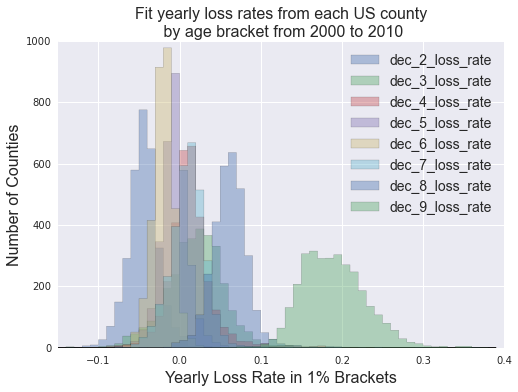

In [78]:
df2 = county_params.drop('dec_1_loss_rate',1)
df2.plot(kind='hist', bins=np.arange(-.15,.4,.01), alpha=.4, histtype='stepfilled')
plt.xlim(-.15,.4)
plt.title('Fit yearly loss rates from each US county\n by age bracket from 2000 to 2010', fontsize=16)
plt.ylabel('Number of Counties', fontsize=16)
plt.xlabel('Yearly Loss Rate in 1% Brackets', fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.savefig('Loss_Histogram.svg')

#### Executing the optimization in parallel

We can take advantage of the multicore nature of most modern machines by using python's `multiprocessing` module to distribute the various counties between each of the cores we have available for the calculation. The basic structure for this piece of code comes from [this gist](https://gist.github.com/yong27/7869662). We are essentially creating a helper function that will apply the fit function to a subset of the census DataFrame, and calling this function once on each of our worker nodes.

In [ ]:
%%capture

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, workers, **kwargs):
    pool = multiprocessing.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

county_params = apply_by_multiprocessing(data[:10], fit, axis=1, workers=4)